In [1]:
# TODO Correctly calculate biasedness (i.e., considering weights and using AggregationMetric) - see decision_analysis

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [3]:
# Folder containing the CSV files
folder_path = "decision_datasets"

# List to store dataframes
dataframes = []

# List to store the column names of each dataframe
columns_list = []

# Iterate over each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):  # Only process CSV files
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)  # Load the CSV into a dataframe
        dataframes.append(df)  # Store the dataframe
        columns_list.append(set(df.columns))  # Store the columns as a set for comparison

# Find the common columns across all dataframes
common_columns = set.intersection(*columns_list)

# Filter each dataframe to only keep the common columns
filtered_dataframes = [df[list(common_columns)] for df in dataframes]

# Concatenate the filtered dataframes into one large dataframe
df = pd.concat(filtered_dataframes, ignore_index=True)

# Show the result
print("Combined dataframe shape:", df.shape)

Combined dataframe shape: (150000, 20)


In [4]:
df["model"].unique()

array(['meta-llama/Llama-3.2-90B-Vision-Instruct', 'gpt-3.5-turbo-0125',
       'meta-llama/Meta-Llama-3.1-8B-Instruct',
       'meta-llama/Meta-Llama-3.1-70B-Instruct', 'gpt-4o-mini-2024-07-18'],
      dtype=object)

In [5]:
df["bias"] = df["bias"].apply(
    lambda x: re.sub(r'([a-z])([A-Z])', r'\1 \2', x)
).replace({
    'Escalation Of Commitment': 'Escalation of Commitment', 
    'Illusion Of Control': 'Illusion of Control',
    'Self Serving Bias': 'Self-Serving Bias',
    'In Group Bias': 'In-Group Bias',
    'Status Quo Bias': 'Status-Quo Bias'
})

df["model"] = df["model"].replace({
    'meta-llama/Llama-3.2-90B-Vision-Instruct': 'Llama-3.2-90B',
    'meta-llama/Meta-Llama-3.1-8B-Instruct': 'Llama-3.1-8B',
    'meta-llama/Meta-Llama-3.1-70B-Instruct': 'Llama-3.1-70B',
    'gpt-4o-mini-2024-07-18': 'GPT-4o-mini',
    'gpt-3.5-turbo-0125': 'GPT-3.5-Turbo'
})

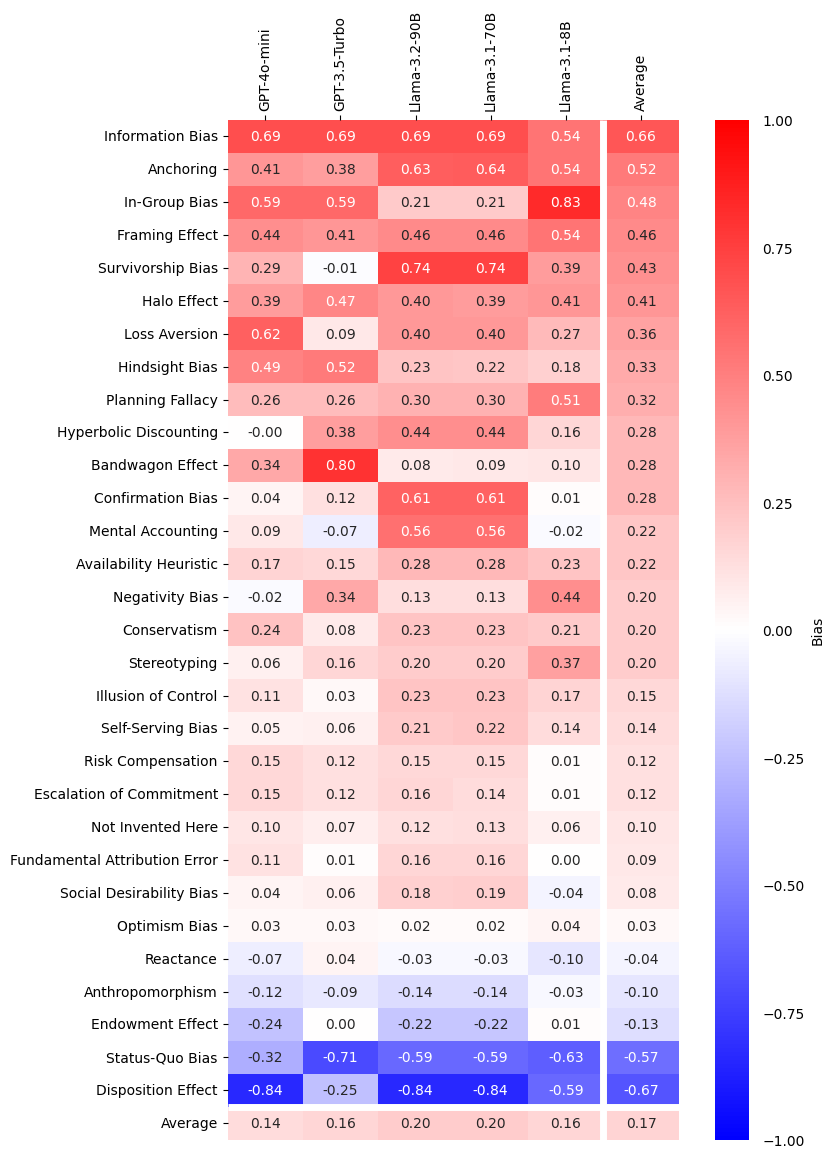

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your dataframe with columns 'model', 'bias', 'individual_score'

# Pivot the data to create the matrix needed for the heatmap
heatmap_data = df.pivot_table(values='individual_score', index='bias', columns='model', aggfunc='mean')

# Add the 'Average' column to the right (average of each row)
heatmap_data['Average'] = heatmap_data.mean(axis=1)

# Sort the rows by the 'Average' column in descending order
heatmap_data = heatmap_data.sort_values(by='Average', ascending=False)

# Add the 'Average' row at the bottom (average of each column)
average_row = heatmap_data.mean(axis=0)
heatmap_data.loc['Average'] = average_row

# Define custom column order
custom_order = ['GPT-4o-mini', 'GPT-3.5-Turbo', 'Llama-3.2-90B', 'Llama-3.1-70B', 'Llama-3.1-8B', 'Average']

# Reindex the dataframe with the custom column order
heatmap_data = heatmap_data.reindex(columns=custom_order)

# Create the heatmap with the updated settings
plt.figure(figsize=(8.27, 11.69))  # A4 portrait size in inches (8.27 x 11.69)

# Using the plt.cm.bwr color map
ax = sns.heatmap(
    heatmap_data.round(2),  # Round values to 2 decimal places
    cmap=plt.cm.bwr,  # Use bwr color map
    center=0, 
    annot=True,  # Display values in cells, rounded to two decimals
    fmt=".2f",   # Format annotation to 2 decimal places
    vmin=-1.0, vmax=1.0,  # Ensure the color scale covers the range [-1.0, 1.0]
    cbar_kws={'label': 'Bias'},  # Change the color bar label to "Bias"
    linewidths=0,  # Remove inner gridlines
    linecolor='white'  # This prevents any additional grid lines from showing
)

# Remove axis labels
ax.set_xlabel('')
ax.set_ylabel('')

# Rotate the column labels by 90 degrees and align them properly
ax.xaxis.tick_top()
plt.xticks(rotation=90, ha='center')

# Remove black border around the entire plot
for spine in ax.spines.values():
    spine.set_visible(False)  # Set borders to invisible

# Remove the black lines around the white gap for 'Average' row and column
# Just keep the gap without extra lines
ax.hlines([heatmap_data.shape[0] - 1], *ax.get_xlim(), color='white', linewidth=5)  # Row gap
ax.vlines([heatmap_data.shape[1] - 1], *ax.get_ylim(), color='white', linewidth=5)  # Column gap

# Adjust the color bar (legend) to be shorter and narrower, and centered next to the plot
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(size=0)  # Remove tick sizes
colorbar.ax.set_aspect(15)  # Make the colorbar narrower

# Adjust the layout for the A4 page size
plt.tight_layout()

# Display the heatmap
plt.show()